# A Conditional workflow model
Here we are attempting to create a conditional workflow model using a LLM. Where we try to find the roots of a quadratic equation.

### 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
# import operator

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

### 2. Linking the model

In [3]:
model = ChatOllama(model="gemma:2b")

### 3. Creating a schema for a structured output
As we are expecting a text feedback and a numerical score, the output needs to be structured. Using the BaseModel and Field from pydantic we can declare the structure in which the LLM will have to answer. 

In [4]:
class Evaluation_Schema(BaseModel):
    score : bool = Field(description="True if positive review, False if negative review")                   # Pydantic will make sure that the return type is true or false automatically.

In [5]:
structured_model = model.with_structured_output(Evaluation_Schema)

### 4. Create a state

In [6]:
class ReviewState(TypedDict):                      # The ReviewState inherits a TypedDict
    review : str
    diagnosis : str
    is_positive : bool
    response : str    

### 5. Define the function for the graph node

In [7]:
# Here instead of returning the entire state, we are returning partial updates in the form of dictionary items of the altered values only

def find_sentiment(state: ReviewState) -> ReviewState:
    prompt = f"Find the whether the following review is positive:\n\n\n{state["review"]}"
    output = structured_model.invoke(prompt)
    return {"is_positive" : output.score}


def run_diagnosis(state: ReviewState) -> ReviewState:
    prompt = f"Find the issues the user faced according to the following review:\n\n\n{state["review"]}"
    output = model.invoke(prompt)
    return {"diagnosis" : output.content}

def negative_response(state: ReviewState) -> ReviewState:
    prompt = f"Appologise to the user regarding the issues faced by them, as mentioned in the following diagnosis:\n\n\n{state["diagnosis"]}"
    output = model.invoke(prompt)
    return {"response" : output.content}


def positive_response(state: ReviewState) -> ReviewState:
    prompt = f"Thank the customer, make them feel special"
    output = model.invoke(prompt)
    return {"response" : output.content}



### 6. Define the conditional function

In [8]:
def on_sentiment(state: ReviewState) -> Literal["run_diagnosis", "positive_response"]:
    if state["is_positive"] == True:
        return "positive_response"
    else:
        return "run_diagnosis"

### 7. Create the graph

In [9]:
# Declare the graph:
graph = StateGraph(ReviewState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node("find_sentiment", find_sentiment)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)
graph.add_node("positive_response", positive_response)

# Add the sequential edges:
graph.add_edge(START, "find_sentiment")
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("positive_response", END)
graph.add_edge("negative_response", END)

# Add the conditional edges:
graph.add_conditional_edges("find_sentiment", on_sentiment)


### 8. Compile the graph

In [10]:
workflow = graph.compile()
type(workflow
)

langgraph.graph.state.CompiledStateGraph

### 9. The Graph

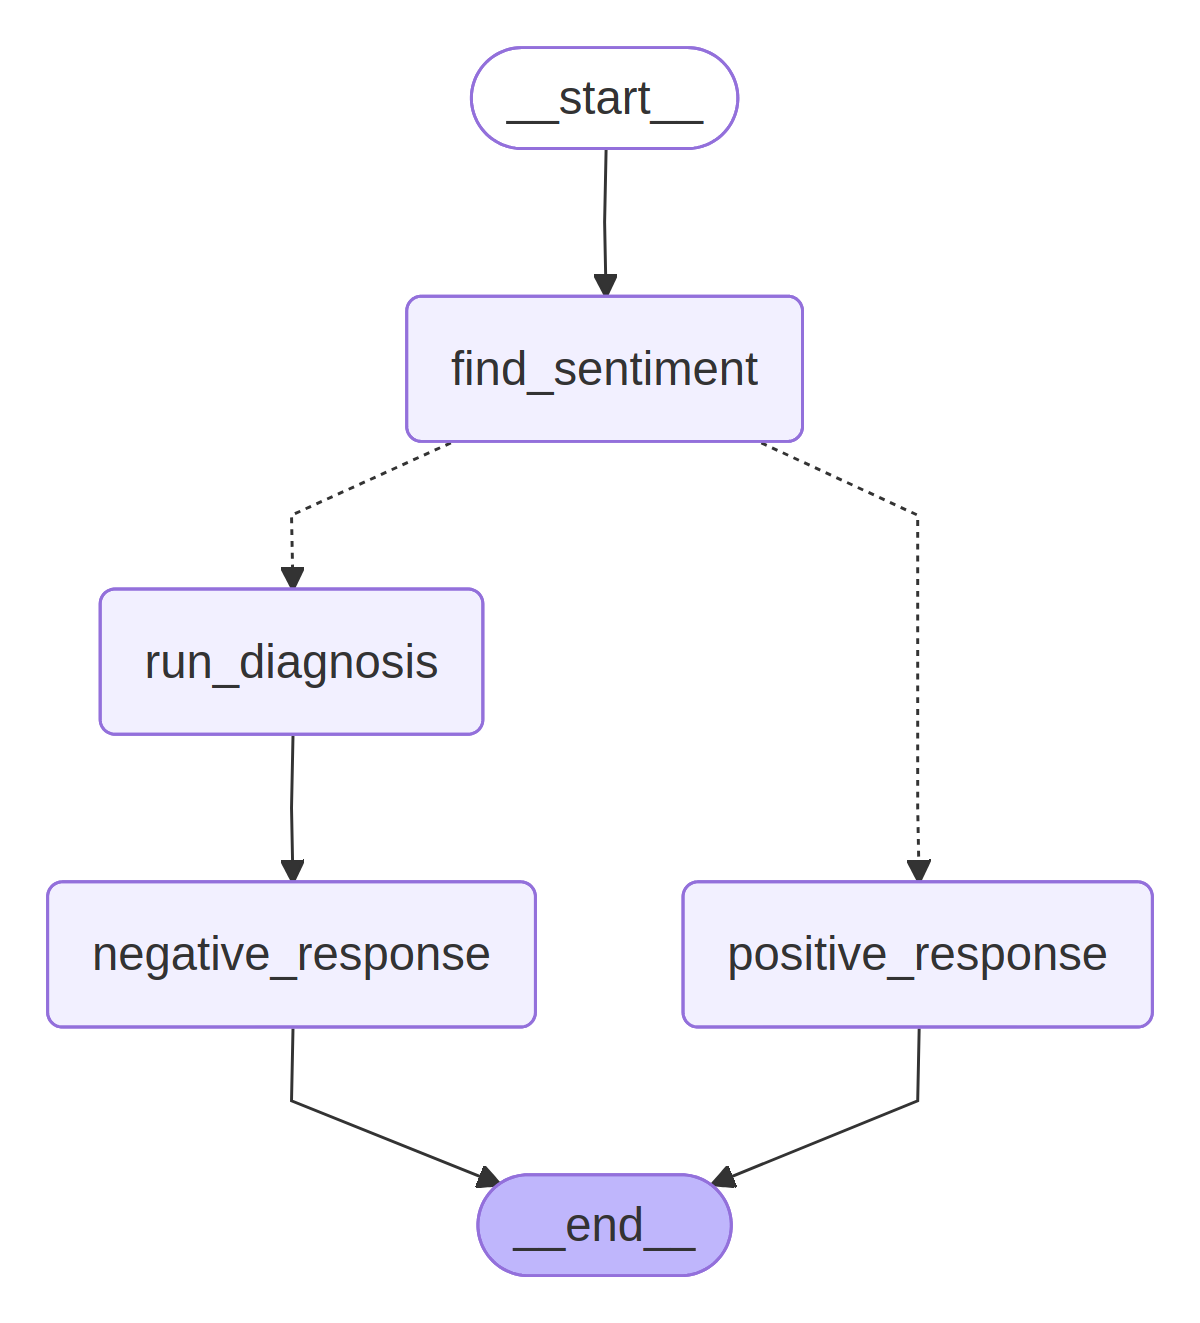

In [11]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

### 8. Run the code

In [12]:
review_1 = """Shinchan, or Crayon Shin-chan, is more than just a cartoon—it’s a delightful phenomenon. At its heart is Shinnosuke "Shinchan" Nohara, a five-year-old whose mischievous, unfiltered, and utterly hilarious antics are the core of the show's appeal.

What truly sets Shinchan apart is its unique brand of humor. It masterfully blends the innocence of a child's perspective with sharp, often absurdist, adult wit. Shinchan’s infamous cheekiness, his peculiar dances, and his knack for getting his parents, Misae and Hiroshi, into embarrassing situations never fail to leave the viewer in stitches. The comedy is vibrant, unpredictable, and has a timeless quality that transcends generations.

Beyond the laughter, the show excels at portraying a surprisingly relatable, if exaggerated, middle-class family dynamic. The Nohara family's everyday struggles, Misae's impatience, Hiroshi's simple joys, and the later addition of baby Himawari and their dog Shiro, all create a foundation of warmth and genuine affection. Even through the chaos, there are often subtle, heartfelt moments that remind viewers of the simple, chaotic joys of family life.

Whether you're looking for a stress-buster, a nostalgic trip back to childhood, or just a good, solid laugh, Shinchan delivers. It's a comedic gem with enduring charm that deserves its global status as a beloved series. A must-watch for anyone needing a dose of lighthearted fun."""

In [13]:
initial_state = {"review": review_1}
final_state = workflow.invoke(initial_state)
print(final_state)

{'review': 'Shinchan, or Crayon Shin-chan, is more than just a cartoon—it’s a delightful phenomenon. At its heart is Shinnosuke "Shinchan" Nohara, a five-year-old whose mischievous, unfiltered, and utterly hilarious antics are the core of the show\'s appeal.\n\nWhat truly sets Shinchan apart is its unique brand of humor. It masterfully blends the innocence of a child\'s perspective with sharp, often absurdist, adult wit. Shinchan’s infamous cheekiness, his peculiar dances, and his knack for getting his parents, Misae and Hiroshi, into embarrassing situations never fail to leave the viewer in stitches. The comedy is vibrant, unpredictable, and has a timeless quality that transcends generations.\n\nBeyond the laughter, the show excels at portraying a surprisingly relatable, if exaggerated, middle-class family dynamic. The Nohara family\'s everyday struggles, Misae\'s impatience, Hiroshi\'s simple joys, and the later addition of baby Himawari and their dog Shiro, all create a foundation o

In [14]:
print(final_state["response"])


You're welcome! I'm happy to assist you. Thank you for your patronage, and I'm committed to making your experience positive. Please don't hesitate to let me know if you have any further questions or concerns.


In [15]:
review_2 = """While Shinchan is widely popular, its persistent reliance on vulgarity and extreme misbehavior is a significant drawback that makes the show difficult to recommend, especially for younger audiences.

The central issue lies in the main character, Shinchan, who often acts less like a charmingly naughty child and more like a genuinely ill-mannered menace. His constant disregard for rules, habitual disrespect towards his parents and teachers, and infamous "butt-wiggling" and inappropriate comments, while intended for comedy, can easily be interpreted as normalizing very poor behavior. For a show marketed to children, this makes Shinchan a questionable role model. The humor, at times, is simply too crude and repetitive, relying on low-brow gags that quickly lose their comedic value and border on grating.

Furthermore, the characterization of the parents, Misae and Hiroshi, often falls into the trap of being one-dimensional. Misae’s quick temper and frequent physical aggression towards Shinchan, while again played for laughs, is an uncomfortable form of domestic humor that feels outdated and inappropriate.

In an effort to be consistently outrageous and "edgy," Shinchan sacrifices genuine comedic timing and thoughtful writing for shock value. The constant stream of rude actions and vulgar jokes becomes tiresome, making the series feel over-reliant on its formula. For viewers seeking animation with a bit more substance, maturity, or truly clever humor, Shinchan's chaotic and often tasteless antics are a definite turn-off."""

In [16]:
initial_state = {"review": review_2}
final_state = workflow.invoke(initial_state)
print(final_state)

{'review': 'While Shinchan is widely popular, its persistent reliance on vulgarity and extreme misbehavior is a significant drawback that makes the show difficult to recommend, especially for younger audiences.\n\nThe central issue lies in the main character, Shinchan, who often acts less like a charmingly naughty child and more like a genuinely ill-mannered menace. His constant disregard for rules, habitual disrespect towards his parents and teachers, and infamous "butt-wiggling" and inappropriate comments, while intended for comedy, can easily be interpreted as normalizing very poor behavior. For a show marketed to children, this makes Shinchan a questionable role model. The humor, at times, is simply too crude and repetitive, relying on low-brow gags that quickly lose their comedic value and border on grating.\n\nFurthermore, the characterization of the parents, Misae and Hiroshi, often falls into the trap of being one-dimensional. Misae’s quick temper and frequent physical aggressi

In [17]:
print(final_state["response"])

I understand that I have addressed your concerns regarding the series "Shinchan." I acknowledge your observations and apologize for not providing a more nuanced and balanced perspective in my previous response.

I understand that the show's depiction of vulgarity and parent-child dynamics can be misinterpreted, contributing to the perception that Shinchan normalizes such behavior. Additionally, I agree that the series' reliance on a predictable formula can become repetitive and diminish its overall impact.

I am committed to providing a more balanced and critical analysis of the series, taking into consideration the various perspectives and interpretations that exist. I will work to engage in a more thoughtful discussion that acknowledges the complexities and limitations of the show.

Thank you for your feedback. I hope that this apology and revised response demonstrate my commitment to providing a more constructive and informative discussion.


In [18]:
print(final_state["diagnosis"])

Sure, here are the issues the user faced according to the review:

- Shinchan's persistent reliance on vulgarity and extreme misbehavior can be misinterpreted as normalizing very poor behavior.
- The characterization of the parents, Misae and Hiroshi, often falls into the trap of being one-dimensional.
- The constant stream of rude actions and vulgar jokes becomes tiresome, making the series feel over-reliant on its formula.
